<a href="https://colab.research.google.com/github/wechulimaven/Projects/blob/main/AI_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import PIL

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
!pip install -q kaggle
!pip install tqdm
!pip install tf-explain
!pip install split-folders tqdm
!cd ~

# !sudo mkdir /root/.kaggle 
# !sudo cp /kaggle.json /root/.kaggle/
# !sudo chmod 600 /root/.kaggle/kaggle.json
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d luisblanche/covidct
! unzip covidct.zip -d covimg

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 94% 81.0M/85.8M [00:00<00:00, 80.4MB/s]
100% 85.8M/85.8M [00:00<00:00, 92.6MB/s]
Archive:  covidct.zip
  inflating: covimg/COVID-CT-MetaInfo.xlsx  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: covimg/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-132.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-133.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-134.png  
  inflating: covimg/CT_COVID/2020.01.24.919183-p27-135.png  
  inflating: covimg/CT_COVID/2020.02.10.20021584-p6-52%0.png  
  inflating: covimg/CT_COVID/2020.02.10.20021584-p6-52%1.png  
  inflating: covimg/CT_CO

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
  
  home_dir = "/content/covimg/"
  filepath = "/content/drive/My Drive/CH Model/bcnn_weights.hdf5"
  modelpath = "/content/drive/My Drive/CH Model/bcnn_model.hdf5"
  img_height = 500
  img_width = 500

In [ ]:
def get_imagesizes(folder):
  max_width = -500
  max_height = -500
  min_width = 500
  min_height = 500
  for files in os.listdir(home_dir+folder):
    image = PIL.Image.open(home_dir+folder+files)
    width, height = image.size
    if width > max_width and height > max_height:
      max_width, max_height = width, height
    if width < min_width and height < min_height:
      min_width, min_height = width, height
    image.close()
  print("Mininum dimensions: ", min_width, min_height)
  print("Maximum dimensions: ", max_width, max_height)
  
print("For COVID Images:")
get_imagesizes("CT_COVID/")
print("\nFor Non-COVID Images:")
get_imagesizes("CT_NonCOVID/")

For COVID Images:
Mininum dimensions:  143 76
Maximum dimensions:  1637 1225

For Non-COVID Images:
Mininum dimensions:  139 108
Maximum dimensions:  1050 819


In [ ]:
splitfolders.ratio(home_dir, output="output", seed=42, ratio=(.8, .1, .1))
!find /content/output/ -type f | wc -l

Copying files: 746 files [00:00, 2377.13 files/s]


746


In [ ]:
# increasing the size of the image training dataset artificially by Image Augmentation technique.
'''
Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images.
It helps to increase dataset variation and ultimately improve the ability of the model to predict new images.
'''

image_gen = ImageDataGenerator(rescale=1./255,shear_range = 0.2,
                                   zoom_range = 0.2, rotation_range = 20)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = image_gen.flow_from_directory(
    '/content/output/train',
    target_size=(img_height,img_width),
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    color_mode = 'rgb'
    # color_mode='grayscale',

)

validation_generator = validation_datagen.flow_from_directory(
    '/content/output/val',  
    target_size=(img_height,img_width), 
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    color_mode = 'rgb'
    # color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    "/content/output/test",
    target_size=(img_height,img_width),
    batch_size=16,
    class_mode='binary',
    color_mode = 'rgb'
    # color_mode='grayscale',
)

Found 596 images belonging to 2 classes.
Found 73 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


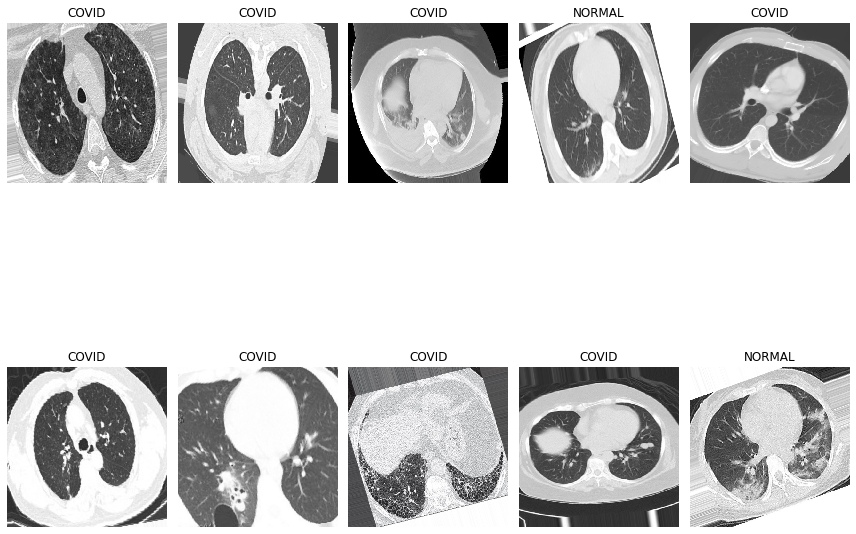

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn.summary()

NameError: ignored

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
reducelr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

step_size_train=train_generator.n//train_generator.batch_size
val_step_size = validation_generator.n//validation_generator.batch_size

history = cnn.fit(train_generator,steps_per_epoch=step_size_train,
                    epochs=4, validation_data=validation_generator, 
                    validation_steps=val_step_size,callbacks=[checkpoint, early], verbose=1)

cnn.save("/content/drive/My Drive/CH Model/bcnn_model.hdf5")

Epoch 1/4


UnimplementedError: ignored

In [ ]:
# pd.DataFrame(cnn.history.history).plot()

In [ ]:
def plotHistory(history):
  acc = history.history.history['acc']
  val_acc = history.history.history['val_acc']
  loss = history.history.history['loss']
  val_loss = history.history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  plt.show()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()
  plt.show()

plotHistory(cnn)

AttributeError: ignored

In [ ]:
cnn.load_weights(filepath)
test_step_size = test_generator.n//test_generator.batch_size

y_test = test_generator.classes
y_pred =  cnn.predict_generator(test_generator,steps=test_step_size+1,verbose=1)
prediction = cnn.predict(test_generator, verbose=1)
# preds = cnn.predict(test_generator,verbose=1)
preds = []
for x in y_pred:
  if x>0.6:
    preds.append(1)
  else:
    preds.append(0)

y_pred = np.asarray(preds)

ValueError: ignored

In [ ]:
print(classification_report(y_true=y_test, y_pred=y_pred,
                            target_names =['NORMAL','POSITIVE']
 ))

              precision    recall  f1-score   support

      NORMAL       0.49      0.53      0.51        36
    POSITIVE       0.55      0.51      0.53        41

    accuracy                           0.52        77
   macro avg       0.52      0.52      0.52        77
weighted avg       0.52      0.52      0.52        77



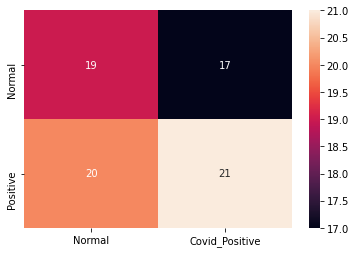

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),index=["Normal", "Positive"],
columns=["Normal", "Covid_Positive"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(img_height, img_width, 4))

for layer in base_model.layers:
	layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1,activation='sigmoid')(x)

vgg = Model(inputs=base_model.input, outputs=x)
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 500, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 500, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 250, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 250, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 250, 250, 128)     147584    
______________________________________________________________

In [ ]:
filepath = "/content/drive/My Drive/CH Model/mnet_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

vgg.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

step_size_train=train_generator.n//train_generator.batch_size
val_step_size = validation_generator.n//validation_generator.batch_size

history = vgg.fit(train_generator,steps_per_epoch=step_size_train,
                    epochs=10, validation_data=validation_generator, 
                    validation_steps=val_step_size,callbacks=[checkpoint, early], verbose=1)

vgg.save("/content/drive/My Drive/CH Model/mnet_model.hdf5")
vgg.save("/content/drive/My Drive/CH Model/mnet_model.hdf5")


Epoch 1/3
37/37 [==============================] - 1904s 51s/step - loss: 10.3711 - acc: 0.5603 - val_loss: 1.5102 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 1.51023, saving model to /content/drive/My Drive/CH Model/mnet_weights.hdf5
Epoch 2/3
37/37 [==============================] - ETA: 0s - loss: 5.0766 - acc: 0.5603 

In [ ]:
test_generator.reset()
x=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(x.shape)
print(y.shape)

(77, 500, 500, 1)
(77,)


In [ ]:
dic = {0:'NORMAL', 1:'COVID-POSITIVE'}
plt.figure(figsize=(20,20))
for i in range(0+67, 9+67):
  plt.subplot(3, 3, (i-67)+1)
  if prediction[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Positive case'.format(prediction[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-prediction[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()